<a href="https://colab.research.google.com/github/hijyun/Overwatch-League-Prediction/blob/main/Prediction/original_player_Feature_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 패키지 설정

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier # 결정 트리
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀

from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score  # ROC곡선 그리기

from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

In [42]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 데이터 읽기

In [7]:
df1 = pd.read_csv('https://raw.githubusercontent.com/hijyun/Overwatch-League-Prediction/main/preprocessing/labeled_phs.csv')

In [8]:
df1 = df1.dropna(subset=['win'])
df1 = df1.dropna(axis=1)

In [10]:
df1.head()

,esports_match_id,map_name,team_name,All Damage Done,Average Time Alive,Critical Hit Accuracy,Critical Hits,Damage - Weapon,Damage Done,Damage Taken,Deaths,Eliminations,Final Blows,Healing Done,Healing Received,Hero Damage Done,Objective Time,Quick Melee Ticks,Self Healing,Self Healing Percent of Damage Taken,Shots Fired,Shots Hit,Shots Missed,Time Alive,Time Building Ultimate,Time Elapsed per Ultimate Earned,Time Holding Ultimate,Time Played,Ultimates Earned - Fractional,Ultimates Used,Weapon Accuracy,win
0,30991,Eichenwalde,Paris Eternal,215077.685584,1053.844839,0.801656,98.0,12260.261844,60290.577886,107667.451329,104.0,262.0,86.0,63062.580216,34021.828452,120581.155776,2297.552069,118.0,4772.284377,0.844678,16452.0,1729.0,4124.0,10801.628323,9850.860287,1837.715771,1428.672042,11785.838174,101.710336,72.0,4.131859,0.0
1,30991,Eichenwalde,Toronto Defiant,258857.476470,1130.489272,0.657890,495.0,17282.651224,53833.725659,121061.942716,94.0,322.0,102.0,74759.061655,41520.140985,107667.451319,2022.140060,104.0,5127.443105,0.962057,56942.0,5549.0,13686.0,10877.382324,9341.070270,1605.899860,2084.574061,11785.838174,102.592067,94.0,3.350676,1.0
2,30991,Havana,Paris Eternal,135271.593583,731.894330,1.052684,58.0,11925.460499,42636.897814,84555.768862,118.0,156.0,56.0,42431.472878,22974.739296,85273.795628,994.132029,106.0,4128.372567,0.714363,8038.0,937.0,1775.0,7502.928225,7018.400204,2416.013788,1415.274041,8631.732713,66.336034,58.0,4.153382,0.0
3,30991,Havana,Toronto Defiant,173850.025950,1481.620544,0.915067,471.0,14435.638403,42277.884436,85702.029863,58.0,344.0,118.0,47998.800494,28430.259984,84555.768871,2286.668068,105.0,4469.151677,1.236224,34944.0,3894.0,9303.0,8055.172240,7012.694203,1293.108833,1271.936037,8631.732713,78.189298,72.0,3.183424,1.0
4,30991,Horizon Lunar Colony,Paris Eternal,163000.693570,1048.642330,0.569059,83.0,12938.384102,50577.573152,92947.477343,92.0,294.0,98.0,54899.992011,28632.823463,101155.146306,1026.466031,79.0,4823.313877,1.522612,11536.0,1507.0,2752.0,9044.662272,7817.912228,1849.852179,1805.488053,9881.643794,78.837408,60.0,5.673673,0.0


In [11]:
X = df1.drop(['win','map_name','esports_match_id','team_name'], axis=1)
y = df1['win']

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2246 entries, 0 to 2281
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   esports_match_id                      2246 non-null   int64  
 1   map_name                              2246 non-null   object 
 2   team_name                             2246 non-null   object 
 3   All Damage Done                       2246 non-null   float64
 4   Average Time Alive                    2246 non-null   float64
 5   Critical Hit Accuracy                 2246 non-null   float64
 6   Critical Hits                         2246 non-null   float64
 7   Damage - Weapon                       2246 non-null   float64
 8   Damage Done                           2246 non-null   float64
 9   Damage Taken                          2246 non-null   float64
 10  Deaths                                2246 non-null   float64
 11  Eliminations     

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2246 entries, 0 to 2281
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   All Damage Done                       2246 non-null   float64
 1   Average Time Alive                    2246 non-null   float64
 2   Critical Hit Accuracy                 2246 non-null   float64
 3   Critical Hits                         2246 non-null   float64
 4   Damage - Weapon                       2246 non-null   float64
 5   Damage Done                           2246 non-null   float64
 6   Damage Taken                          2246 non-null   float64
 7   Deaths                                2246 non-null   float64
 8   Eliminations                          2246 non-null   float64
 9   Final Blows                           2246 non-null   float64
 10  Healing Done                          2246 non-null   float64
 11  Healing Received 

# 전처리 및 데이터 분할

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()       # 범주형 변수를 0부터 시작하는 정수형 숫자로 변환
y = le.fit_transform(y)   


In [15]:
y

array([0, 1, 0, ..., 1, 0, 1])

## train data , test data split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100, stratify=y)

# 모델

In [54]:
logistic = LogisticRegression(solver='liblinear',penalty='l2',C= 0.1,random_state=1)
tree = DecisionTreeClassifier(max_depth=4,criterion='entropy',random_state=1)
knn = KNeighborsClassifier(n_neighbors=41,p=2,metric='minkowski')

voting_estimators = [('logistic', logistic), ('tree', tree), ('knn', knn)]

voting = VotingClassifier(estimators = voting_estimators,voting='soft')

forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)

lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(tree_method='hist',random_state=41)

adaboost = AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=100,
                                learning_rate = 0.01, 
                                random_state=42)

clf_labels = ['Logistic regression', 'Decision tree',  'Majority voting','Random forest','Ada boost','XGB','LIGHTGBM']

all_clf = [logistic, tree, voting, forest,adaboost,xgb,lgb]

### AUC 검정

In [49]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

ROC AUC: 0.968 (+/- 0.011) [Logistic regression]
ROC AUC: 0.955 (+/- 0.009) [Decision tree]
ROC AUC: 0.855 (+/- 0.031) [KNN]
ROC AUC: 0.972 (+/- 0.008) [Majority voting]
ROC AUC: 0.965 (+/- 0.011) [Random forest]
ROC AUC: 0.961 (+/- 0.012) [Ada boost]
ROC AUC: 0.968 (+/- 0.007) [XGB]
ROC AUC: 0.965 (+/- 0.010) [LIGHTBM]


# 특성 중요도

In [23]:
forest.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [27]:
features = X.columns.values

In [30]:
zip(forest.feature_importances_,features)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


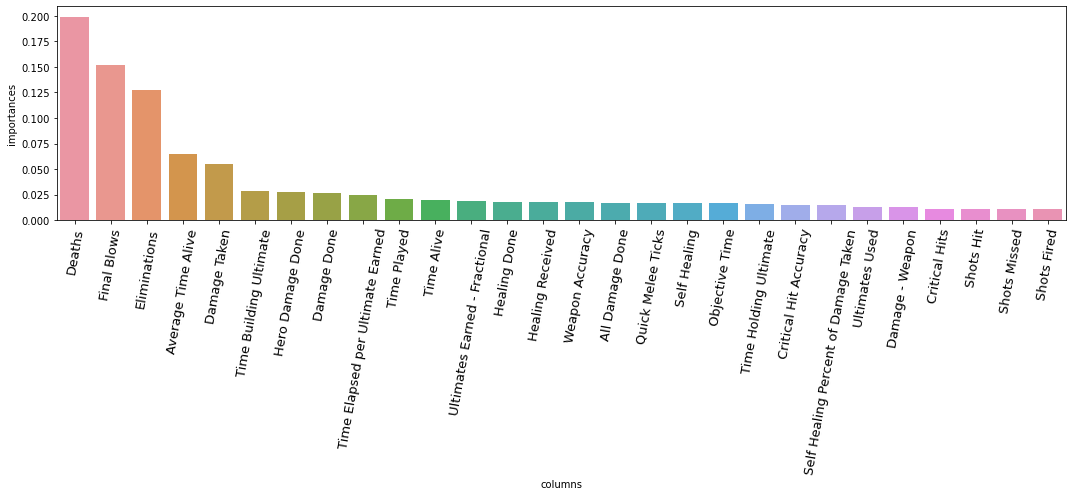

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance = forest.feature_importances_
# plot
df_fi = pd.DataFrame({'columns':X.columns, 'importances':feature_importance})
df_fi = df_fi[df_fi['importances'] > 0] # importance가 0이상인 것만 
df_fi = df_fi.sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.tight_layout()
plt.show()

### ROC 커브

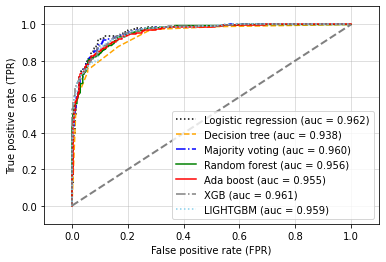

In [55]:
colors = ['black', 'orange', 'blue', 'green','red','gray','skyblue']
linestyles = [':', '--', '-.', '-','solid','dashdot','dotted']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr) # 교차검증 X
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 정오 분류표로 검정

In [ ]:
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 71
정확도: 0.895
정밀도: 0.901
재현율: 0.887
F1: 0.894


# 모수 튜닝

## voting

In [ ]:
voting.get_params()

{'estimators': [('logistic',
   LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                      warm_start=False)),
  ('tree',
   DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, presort='deprecated',
                          random_state=1, splitter='best')),
  ('knn',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                        metric_params=None, n_jobs=None, n_neighbors=41, p=2,
        

In [ ]:
parms = {'logistic__C':[0.001,0.1,100.0],
         'tree__max_depth' :  [1,2,3,4,5],
         'knn__n_neighbors':[1,2,3,4,5]}


grid = GridSearchCV(estimator=voting, 
                    param_grid=parms,
                    cv=10,
                    scoring='roc_auc',
                    iid=False)




In [ ]:
grid.fit(X_train,y_train)

In [ ]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  print("%0.3f +/- %0.3f %r" % (grid.cv_results_['mean_test_score'][r],
        grid.cv_results_['std_test_score'][r] / 2.0,
        grid.cv_results_['params'][r]))


In [ ]:
print('최적의 파타미터: %s' % grid.best_params_)
print('ACU: %.3f' % grid.best_score_)


## adaboost

In [56]:
adaboost.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=4, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1, splitter='best'),
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 4,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': 

In [ ]:
parms = {'n_estimators': [100,200,300,500,700,1000]
             }


grid = GridSearchCV(estimator=adaboost, 
                    param_grid=parms,
                    cv=10,
                    scoring='roc_auc',
                    iid=False)

grid.fit(X_train,y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  print("%0.3f +/- %0.3f %r" % (grid.cv_results_['mean_test_score'][r],
        grid.cv_results_['std_test_score'][r] / 2.0,
        grid.cv_results_['params'][r]))

In [ ]:
print('최적의 파타미터: %s' % grid.best_params_)
print('ACU: %.3f' % grid.best_score_)